In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and prepare data
data = pd.read_csv('data.csv')

# Reshape data
monthly_data = pd.melt(data, id_vars=['ITEM DESCRIPTION'],
                       value_vars=[col for col in data.columns if 'JANUARY' in col or 'FEBRUARY' in col or 'MARCH' in col or 'APRIL' in col or 'MAY' in col or 'JUNE' in col or 'JULY' in col or 'AUGUST' in col or 'SEPTEMBER' in col or 'OCTOBER' in col or 'NOVEMBER' in col or 'DECEMBER' in col],
                       var_name='Month_Year', value_name='Consumption')

# Extract year and month
monthly_data['Year'] = monthly_data['Month_Year'].str.split('_').str[1]
monthly_data['Month'] = monthly_data['Month_Year'].str.split('_').str[0]

# Create a date column
monthly_data['Date'] = pd.to_datetime(monthly_data['Month'] + ' ' + monthly_data['Year'], format='%B %Y')

# Drop unnecessary columns
monthly_data = monthly_data.drop(columns=['Month_Year'])

# Sort by date
monthly_data = monthly_data.sort_values(by='Date')

# Set Date as index
monthly_data.set_index('Date', inplace=True)
monthly_data.head()


,ITEM DESCRIPTION,Consumption,Year,Month
Date,,,,
2021-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,8,2021,JANUARY
2021-01-01,Ringer Lactate - Compound Sodium Lactate Injec...,122,2021,JANUARY
2021-01-01,Ring File 79,34,2021,JANUARY
2021-01-01,Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5...,4,2021,JANUARY
2021-01-01,Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25c...,0,2021,JANUARY


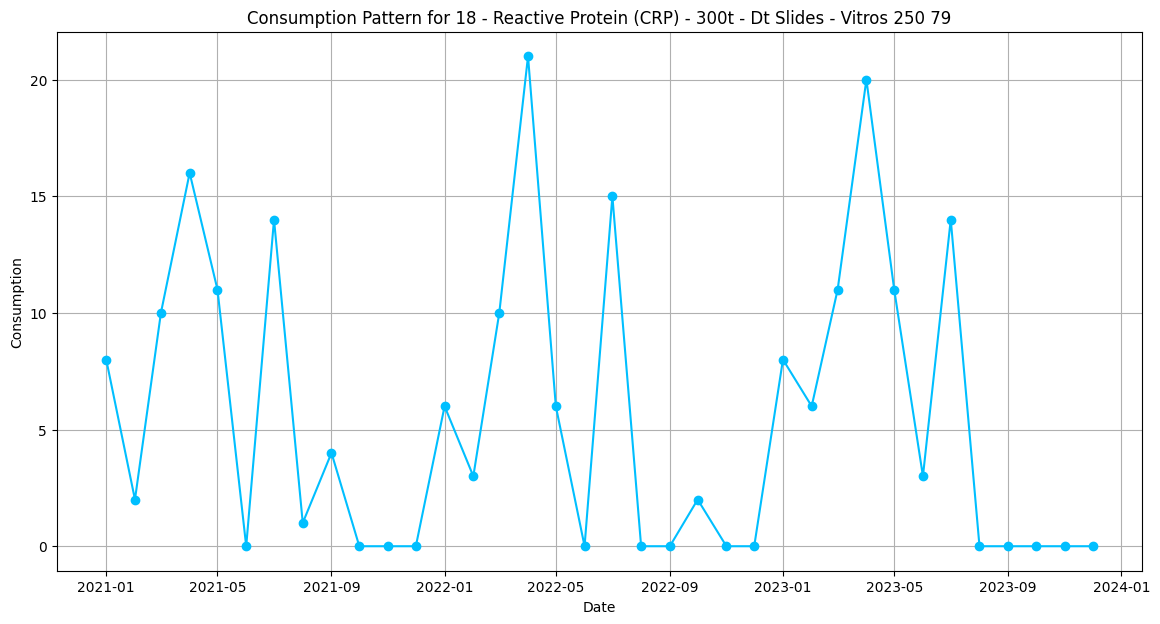

In [122]:
# Plot consumption patterns for a sample item
sample_item = monthly_data['ITEM DESCRIPTION'].unique()[0]
sample_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == sample_item]

plt.figure(figsize=(14, 7))
plt.plot(sample_data.index, sample_data['Consumption'], marker='o', linestyle='-', color='deepskyblue')
plt.title(f'Consumption Pattern for {sample_item}')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()


In [123]:
# Prepare for each item
items = monthly_data['ITEM DESCRIPTION'].unique()

future_predictions_all_items = []

for item in items:
    # Filter data for the current item
    item_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item].copy()

    # Prepare features and target
    item_data['Month'] = item_data.index.month
    item_data['Year'] = item_data.index.year
    item_data['Day_of_Week'] = item_data.index.dayofweek

    # Example target variable: Predict next month's consumption
    item_data['Next_Consumption'] = item_data['Consumption'].shift(-1)
    item_data = item_data.dropna()

    # Features and target
    X = item_data[['Month', 'Year', 'Day_of_Week']]
    y = item_data['Next_Consumption']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize Random Forest regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Item: {item} - Mean Squared Error: {mse}')

    # Predict next month's consumption for the next 12 months
    future_dates = pd.date_range(start=item_data.index.max() + pd.DateOffset(months=1), periods=12, freq='MS')
    future_features = pd.DataFrame({
        'Month': future_dates.month,
        'Year': future_dates.year,
        'Day_of_Week': future_dates.dayofweek
    })

    # Predict future consumption
    future_predictions = model.predict(future_features)

    # Create DataFrame for future predictions
    future_df = pd.DataFrame({'Date': future_dates, 'Item': item, 'Predicted_Consumption': future_predictions})
    future_predictions_all_items.append(future_df)

# Combine all future predictions into a single DataFrame
final_predictions = pd.concat(future_predictions_all_items)
final_predictions.head()

Item: 18 - Reactive Protein (CRP) - 300t - Dt Slides - Vitros 250 79 - Mean Squared Error: 21.07547142857143
Item: Ringer Lactate - Compound Sodium Lactate Injection Ip - 500ml 79 - Mean Squared Error: 68.25167142857141
Item: Ring File 79 - Mean Squared Error: 18.33322857142857
Item: Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5cm 79 - Mean Squared Error: 0.22100000000000003
Item: Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25cm 79 - Mean Squared Error: 0.33679999999999993
Item: Ribbon - Barcode Label Printer Ribbon Zebra Tlc Label Roll+Wax 79 - Mean Squared Error: 26.712357142857144
Item: RF Reagent Pack 79 - Mean Squared Error: 3.3015857142857143
Item: Reservoir Bag - Infant 79 - Mean Squared Error: 1.2506285714285712
Item: Reservoir Bag - Child 79 - Mean Squared Error: 0.8187714285714286
Item: Reservoir Bag - Adult 79 - Mean Squared Error: 1.0891285714285714
Item: Referral Form (H-1) - A4 79 - Mean Squared Error: 2.5813285714285716
Item: Recordable Cd With Cover 79 - Mean Squared Er

,Date,Item,Predicted_Consumption
0,2023-12-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,6.81
1,2024-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,11.34
2,2024-02-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,10.91
3,2024-03-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,10.52
4,2024-04-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,17.05


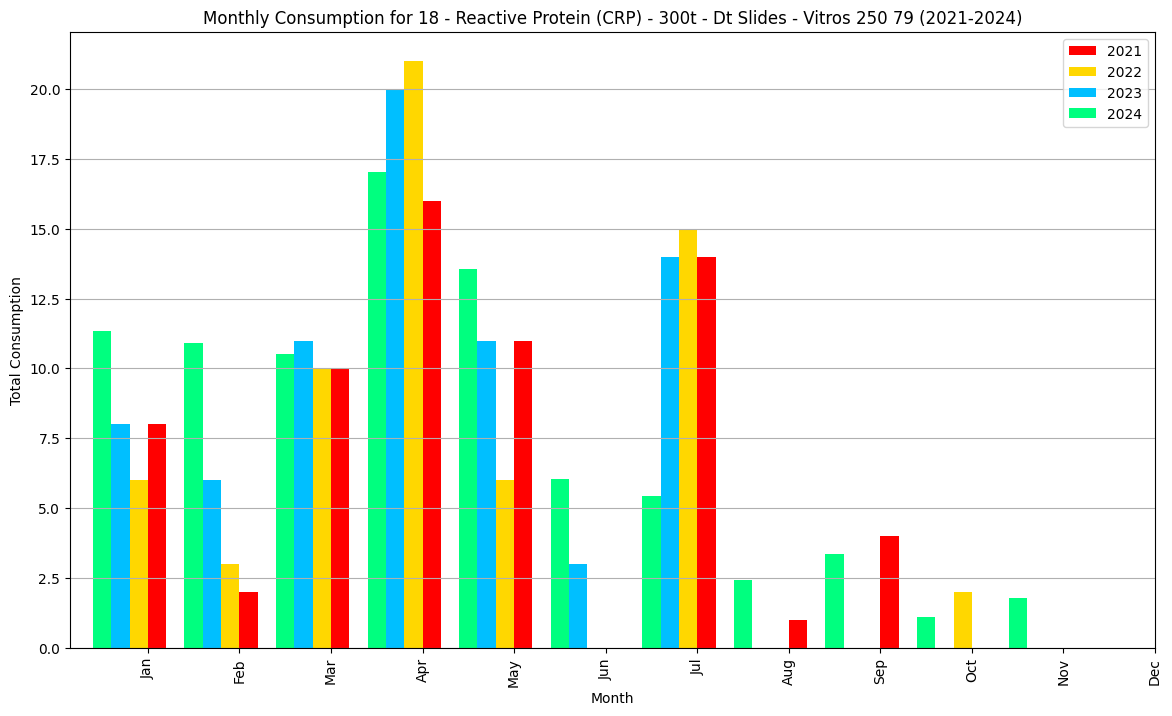

In [124]:
# Select a specific item for detailed analysis
specific_item = items[0]

# Historical data for the specific item
historical_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == specific_item].copy()

# Predicted data for the specific item
predicted_data = final_predictions[final_predictions['Item'] == specific_item].copy()

# Add year and month columns to historical data
historical_data['Year'] = historical_data.index.year
historical_data['Month'] = historical_data.index.month

# Add year and month columns to predicted data
predicted_data['Year'] = predicted_data['Date'].dt.year
predicted_data['Month'] = predicted_data['Date'].dt.month

# Plot the bar graph
plt.figure(figsize=(14, 8))

# Historical data for 2021
hist_2021 = historical_data[historical_data['Year'] == 2021].groupby('Month')['Consumption'].sum()
hist_2021.plot(kind='bar', color='red', position=0, width=0.2, label='2021', align='center')

# Historical data for 2022
hist_2022 = historical_data[historical_data['Year'] == 2022].groupby('Month')['Consumption'].sum()
hist_2022.plot(kind='bar', color='gold', position=1, width=0.2, label='2022', align='center')

# Historical data for 2023
hist_2023 = historical_data[historical_data['Year'] == 2023].groupby('Month')['Consumption'].sum()
hist_2023.plot(kind='bar', color='deepskyblue', position=2, width=0.2, label='2023', align='center')

# Predicted data for 2024
pred_2024 = predicted_data[predicted_data['Year'] == 2024].groupby(predicted_data['Date'].dt.month)['Predicted_Consumption'].sum()
pred_2024.plot(kind='bar', color='springgreen', position=3, width=0.2, label='2024', align='center')

plt.title(f'Monthly Consumption for {specific_item} (2021-2024)')
plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.legend()
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.show()
